## Clustering !
Your task is to explore this synthetic telecom churn dataset to identify any patterns that might be useful for targeted advertising. 

### Churn dataset description 
The dataset contains information about telecommunications customer churn behaviour. It is a fictional telco company that provided mobile phone and internet services and the data is synthetic.   
It contains approximately 4000 records, each representing a customer, and contains a total of 8 variables/ features. These variables cover a variety of aspects related to the customer behaviour, demographic and contract types.


In [1]:
### loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_circles, make_moons

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from pyclustertend import hopkins
from sklearn.metrics import silhouette_score

import datetime
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# for those who cannot pip install pyclustertend
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkins_stats(X):
    """
    Calculate the Hopkins statistic to measure the clustering tendency of data.

    Parameters:
        X (pd.DataFrame): The input data with rows representing samples and columns representing features.

    Returns:
        float: The Hopkins statistic value.
    """
    d = X.shape[1]  # Number of columns (features)
    n = len(X)     # Number of rows (samples)
    m = int(0.1 * n)  # Number of random points to be chosen for the calculation

    # Fit nearest neighbors on the input data
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    # Generate m random points and calculate their distances
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []  # List to store distances of random points to their nearest neighbor among uniformly distributed points
    wjd = []  # List to store distances of random points to their nearest neighbor among the data points

    for j in range(0, m):
        # Calculate the distance of a random point to its nearest neighbor among uniformly distributed points
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(X, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])

        # Calculate the distance of a random point to its nearest neighbor among the data points
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    # Calculate the Hopkins statistic
    H = sum(ujd) / (sum(ujd) + sum(wjd))

    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [3]:
## Read in comma separated file 

df = pd.read_csv('./churn_data.csv',index_col = [0])

In [4]:
df.head()

,prev_month_usage,tenure,contract_type,dob,country,paperless,mob_data,churn
0,NaN,17.0,Fixed Contract,03 August 1978,England,1,3.6708,1
1,1.278289,17.0,Fixed Contract,27 November 1972,Wales,0,1.4776,0
2,5.044904,14.0,Fixed Contract,09 December 1981,England,1,5.0345,1
3,NaN,21.0,Rolling Contract,31 May 1992,Wales,1,11.3131,1
4,3.384626,23.0,Fixed Contract,28 December 1976,Scotland,1,2.6148,0


### Data cleaning

In [5]:
def clean(df):
    ## Removing missing values 
    df.dropna(inplace=True)
    
    # Changing categorical variables value 
    df['contract_type'] = df['contract_type'].str.replace('rolling contract','Rolling Contract')
    df['contract_type'] = df['contract_type'].str.replace('Fixed-contract','Fixed Contract')
    
    # Assuming your DataFrame is called df and the birth date column is 'birth_date'
    df['dob'] = pd.to_datetime(df['dob'], dayfirst = True)
    current_date = datetime.datetime.now()
    df['age'] = (current_date - df['dob']).astype('<m8[Y]')
    
    return df

In [6]:
df = clean(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3812 entries, 1 to 3999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   prev_month_usage  3812 non-null   float64       
 1   tenure            3812 non-null   float64       
 2   contract_type     3812 non-null   object        
 3   dob               3812 non-null   datetime64[ns]
 4   country           3812 non-null   object        
 5   paperless         3812 non-null   int64         
 6   mob_data          3812 non-null   float64       
 7   churn             3812 non-null   int64         
 8   age               3812 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 297.8+ KB


In [7]:
num_df = df[['prev_month_usage','tenure','mob_data','age']]
num_df.head()

,prev_month_usage,tenure,mob_data,age
1,1.278289,17.0,1.4776,50.0
2,5.044904,14.0,5.0345,41.0
4,3.384626,23.0,2.6148,46.0
5,1.634897,26.0,1.9298,48.0
6,11.013085,21.0,10.5953,25.0


In [8]:
# Here we will scale the features using StandardScaler 
scaled_df = StandardScaler().fit_transform(num_df)

# You can also try MinMaxScaler
#num_df = MinMaxScaler().fit_transform(num_df)

In [9]:
scaled_df.shape

(3812, 4)

In [10]:
# (1-H)
from pyclustertend import hopkins 
hopkins(scaled_df,3812)

0.061808899310937984

due to 1-H, the lower the higher the clusterability 

In [11]:
# for those who cannot use pyclustertend 

num_df_scaled = pd.DataFrame(scaled_df)
num_df_scaled.columns =['prev_month_usage','tenure','mob_data','age']
hopkins_stats(num_df_scaled)

0.9355771572082743

In [12]:
from sklearn.cluster import KMeans

## Check which number of clusters works best 
n_cluster_list = [2,3,4,5,8,10,20,50,100,500] # there can't be more clusters than n

elb = []
silhouette = []
for n_clusters in n_cluster_list:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(scaled_df)
   #Finding the average silhouette score
   silhouette_avg = silhouette_score(scaled_df, cluster_labels)
   silhouette.append(silhouette_avg)
   print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
   #Finding the average SSE"
   elb.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center/within-cluster sum of squares



For n_clusters = 2 The average silhouette_score is : 0.43530028988598235
For n_clusters = 3 The average silhouette_score is : 0.32492417395442097
For n_clusters = 4 The average silhouette_score is : 0.33472985739530775
For n_clusters = 5 The average silhouette_score is : 0.3250037026979182
For n_clusters = 8 The average silhouette_score is : 0.3013364283886943
For n_clusters = 10 The average silhouette_score is : 0.28914445545343975
For n_clusters = 20 The average silhouette_score is : 0.2582380534438584
For n_clusters = 50 The average silhouette_score is : 0.22485858099199793
For n_clusters = 100 The average silhouette_score is : 0.20543112571821917
For n_clusters = 500 The average silhouette_score is : 0.22068747521961873


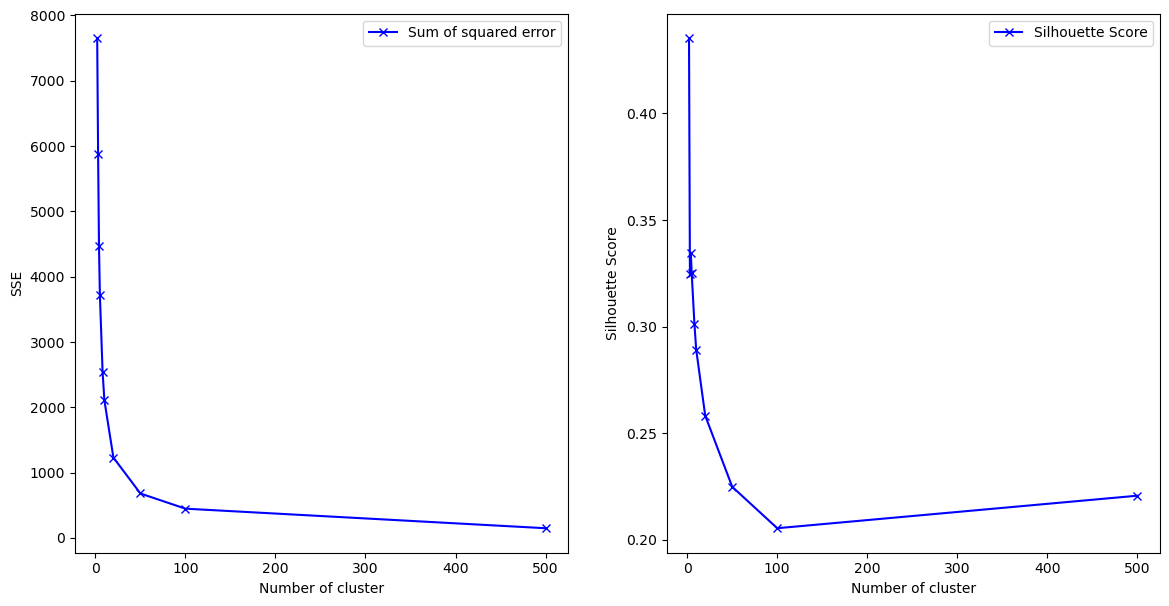

In [13]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(n_cluster_list, elb,'bx-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(n_cluster_list, silhouette,'bx-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [14]:
x

,prev_month_usage,tenure,mob_data,age,Cluster
1,1.278289,17.0,1.4776,50.0,0
2,5.044904,14.0,5.0345,41.0,0
4,3.384626,23.0,2.6148,46.0,0
5,1.634897,26.0,1.9298,48.0,0
6,11.013085,21.0,10.5953,25.0,1


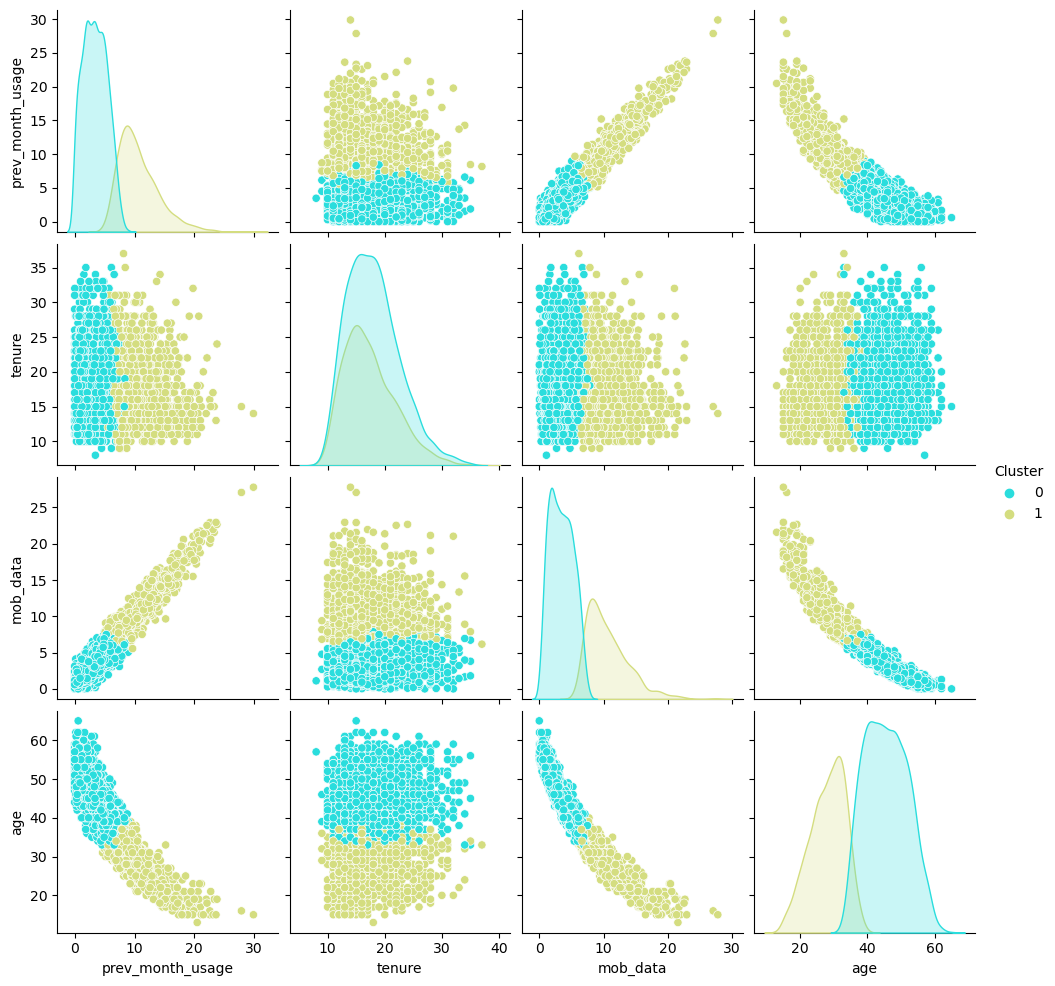

In [15]:
## Scatter matrix plot 

sns.pairplot(num_df, hue="Cluster",palette="rainbow")

In [17]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns


palette = sns.color_palette("bright", 10)

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)  
        

In [18]:
df_2 = df[['prev_month_usage','tenure','mob_data','age']]
X_clustered = pd.DataFrame(scaled_df, index=df_2.index, columns=df_2.columns)
X_clustered.head()

,prev_month_usage,tenure,mob_data,age
1,-1.097491,-0.162179,-1.088398,1.066268
2,-0.235209,-0.818005,-0.246886,0.189350
4,-0.615292,1.149474,-0.819352,0.676526
5,-1.015853,1.805300,-0.981414,0.871397
6,1.131072,0.712256,1.068721,-1.369616


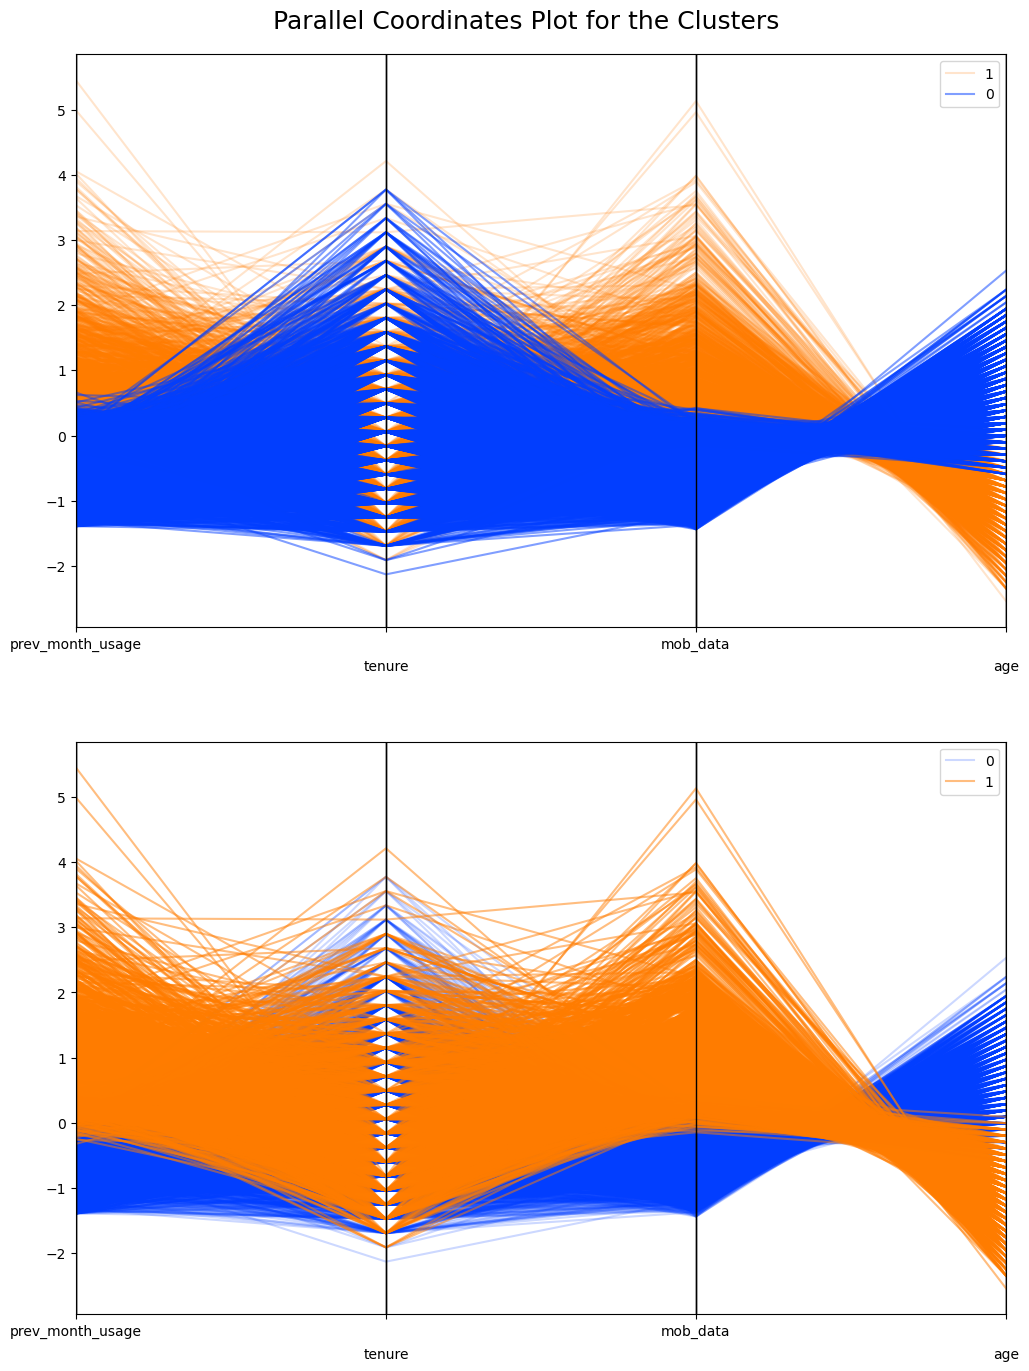

In [19]:
# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(scaled_df, index=df_2.index, columns=df_2.columns)
X_clustered["cluster"] = kmeans.labels_

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(X_clustered, 2)

In [20]:
dbscan = DBSCAN().fit(scaled_df)

db_labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)
unique_labels = len(set(db_labels))

print('Estimated number of clusters: %d' % unique_labels)

Estimated number of clusters: 2


In [21]:
db_c = DBSCAN().fit_predict(scaled_df)

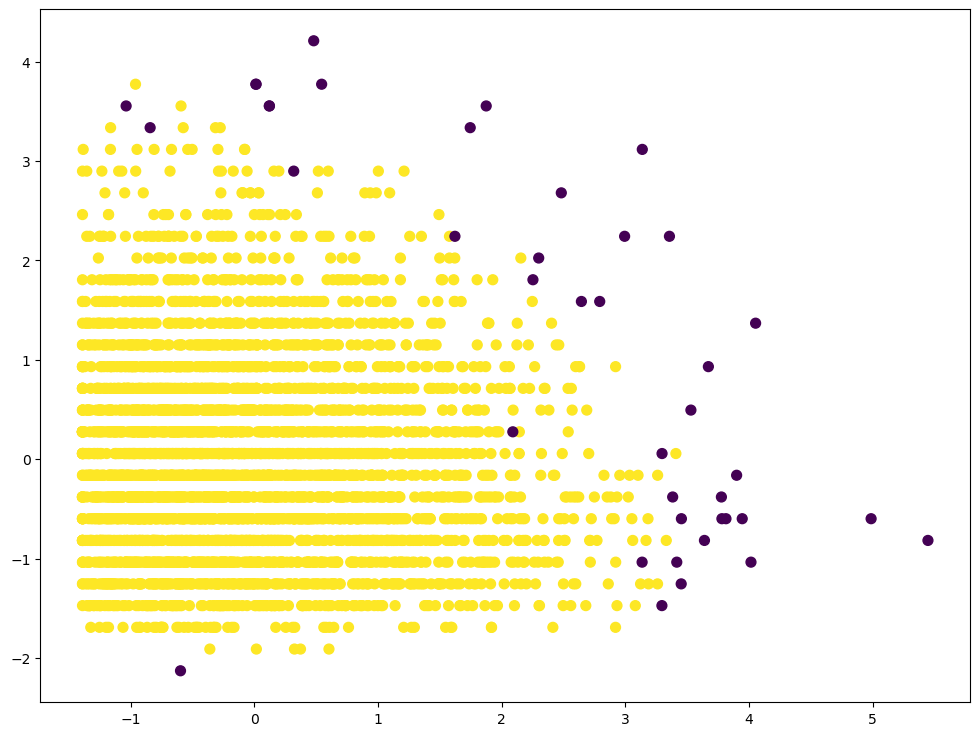

In [23]:
plt.figure(figsize=(12,9))
plt.scatter(scaled_df[:, 0], scaled_df[:, 1], c=db_c, s=50, cmap='viridis')

In [24]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(scaled_df)
distances, indices = nbrs.kneighbors(scaled_df)

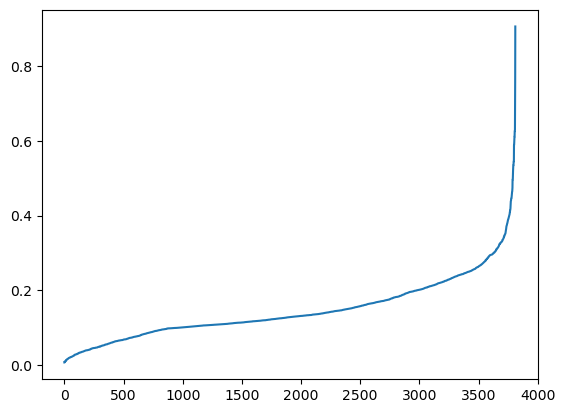

In [25]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [27]:
db_c = DBSCAN(eps =0.3).fit_predict(scaled_df)

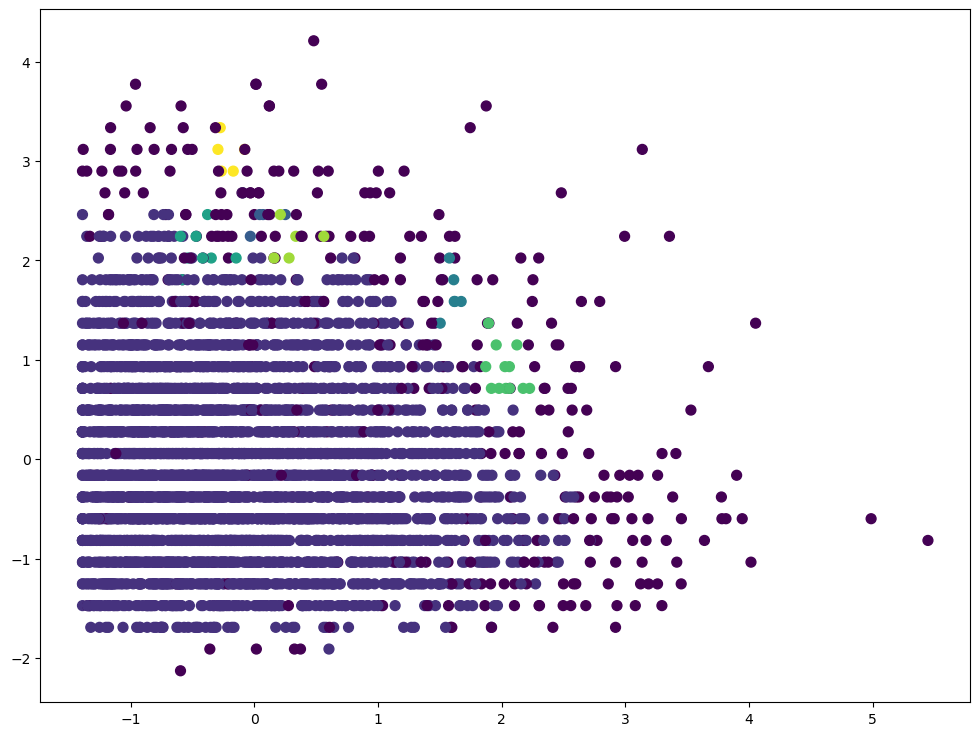

In [29]:
plt.figure(figsize=(12,9))
plt.scatter(scaled_df[:, 0], scaled_df[:, 1], c=db_c, s=50, cmap='viridis')